# Abbildung für das Treffen mit dem Synfonyprojekt am 11.06.2019

Die Idee ist folgende:

1. Zwei Beispiele für den 18.6.2013 heraussuchen &rarr; Standardvariante und HRV-Interpolation
2. Vergleich von SATCAST mit Filterung mit Wolkentyp und NWCSAF-CI v2018
3. Auch Radar und Linetdaten mit einbauen
4. Ziel: zeigen, was geht

# 1. Fallbeispiele heraussuchen
Der 18.06.2013 wurde ausgewählt, weil wir da das NWCSAF-CI-Produkt in der 2018er Version da haben. 

In [226]:
import numpy as np
import xarray as xr
import glob
import pandas as pd

import matplotlib.pyplot as plt
% matplotlib inline

from analysis_tools import grid_and_interpolation as gi

import sys
sys.path.append("/vols/satellit/home/lenk/lib/citroPy")
import ci_config
import ci_interface_tools
import ci_main_tools

sys.path.append("/vols/satellit/home/lenk/utils/tracking")
import optical_flow_tracking as oft
import object_tracking as ot
import tracking_common as tco

sys.path.append("/vols/satellit/home/lenk/proj/2018-05_cieval/python/filtered_graph_branch/")
import cieval_data_io as cdio

import fixed_colourbar as fc
import analysis_tools.optical_flow as oflow

import MSGtools as mst

import h5py

from io_tools import radolan

import l15_msevi.msevi as msv
import load_satellite_data as lsd

In [149]:
r =radolan.Radolan()

In [228]:
tlist = pd.date_range(start="20130618t1200",end="20130618t1400",freq="5min")

In [233]:
mst.get_nwcsaf_prod??

In [239]:
sat_data = {f:[] for f in ['WV_062','WV_073','IR_087','IR_108','IR_120','HRV','CT']}

for t in tlist:
    sd = lsd.load_satellite_data_multichannel(t.to_pydatetime(),
                                              channel_list=['WV_062','WV_073','IR_087','IR_108','IR_120','HRV'])
    
    ct = mst.get_nwcsaf_prod("CT",t.to_pydatetime(),calibrate=True)
    sat_data['CT'].append(np.array(ct))
    
    for f in ['WV_062','WV_073','IR_087','IR_108','IR_120','HRV']:
        sat_data[f].append(np.array(sd[f]))

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file


In [237]:
flow5 = oft.calculate_optical_flow(sat_data['IR_108'],'farnebaeck',filtering=True)
flow15 = oft.calculate_optical_flow(sat_data['IR_108'][::3],'farnebaeck',filtering=True)

In [311]:
interest_fields = {}

In [242]:
sat_data['IR_108'][0]

array([[266.78618636, 265.0734668 , 263.85377717, ..., 253.77900752,
        254.96381539, 259.71585976],
       [261.17882183, 260.26755425, 260.63328194, ..., 255.35473717,
        252.77743622, 254.17597903],
       [264.20405704, 262.25916134, 260.99737872, ..., 265.24628694,
        262.97163919, 261.17882183],
       ...,
       [312.05086418, 312.93183744, 313.58868505, ..., 293.99404951,
        293.8655192 , 294.12243118],
       [312.82204127, 313.26067326, 313.80690492, ..., 293.8655192 ,
        293.99404951, 293.99404951],
       [313.47943895, 313.80690492, 313.80690492, ..., 293.99404951,
        293.99404951, 294.12243118]])

In [312]:
interest_fields['wv062_ir108'] = np.array(sat_data['WV_062']) - np.array(sat_data['IR_108'])
interest_fields['wv062_wv073'] = np.array(sat_data['WV_062']) - np.array(sat_data['WV_073'])
interest_fields['ir087_ir108'] = np.array(sat_data['IR_087']) - np.array(sat_data['IR_108'])
interest_fields['tri'] = (np.array(sat_data['IR_087']) - np.array(sat_data['IR_108'])) -\
                          (np.array(sat_data['IR_108']) - np.array(sat_data['IR_120']))
interest_fields['ir108'] = np.array(sat_data['IR_108'])

In [283]:
thresholds = {'wv062_ir108': (-25,-10),
              'ir108': (253,273),
              'wv062_wv073':(-25,3),
              'ir087_ir108': (-10,0),
              'ir087_ir108_dt5': (0,10),
              #'ir087_ir108_dt15': (0,10),
              'tri_dt5': (0,10),
              #'tri_dt15': (0,10),
              'wv062_wv073_dt5': (0.2,10),
              #'wv062_wv073_dt15': (0.2,10),
              'ir108_dt5': (-50,-4)}#,
              #'ir108_dt15': (-50,-4)}

In [313]:
static_fields = ['wv062_ir108', 'wv062_wv073','ir087_ir108','tri','ir108']
for i,fl in enumerate(flow5):
    for f in static_fields:
        if not "{}_dt5".format(f) in interest_fields:
            interest_fields["{}_dt5".format(f)] = []
            interest_fields["{}_dt5".format(f)].append(np.zeros((600,800)))
            
        f_shifted = tco.morph_field(interest_fields[f][i],fl[...,0],fl[...,1])
        
        #delta = np.array(interest_fields[f][i+1] - f_shifted)
        delta = np.array(f_shifted-interest_fields[f][i+1])
        interest_fields["{}_dt5".format(f)].append(delta)

In [294]:
f_shifted.shape

(600, 800)

In [295]:
delta.shape

(600, 800)

In [254]:
for i,fl in enumerate(flow15):
    for f in static_fields:
        if not "{}_dt15".format(f) in interest_fields:
            interest_fields["{}_dt15".format(f)] = []
            interest_fields["{}_dt15".format(f)].append(np.zeros((153,153)))
            
        f_shifted = tco.morph_field(interest_fields[f][i],fl[...,0],fl[...,1])
        
        interest_fields["{}_dt15".format(f)].append(interest_fields[f][i+1] - f_shifted)

In [317]:
isum = dict()
for k in thresholds.keys():
    lo = thresholds[k][0]
    up = thresholds[k][1]
    
    ind = np.zeros_like(interest_fields[k])
    
    if_val = interest_fields[k]
    valid_idx = np.where(np.logical_and(if_val>lo, if_val<up))
    
    ind[valid_idx] = 1
    isum[k] = ind

Jetzt summieren wir alles auf.

In [315]:
summe = np.zeros_like(isum['ir108'])
for i in xrange(len(isum['ir108'])):
   
    for f in isum.keys():
        summe[i] = summe[i] + isum[f][i]
        
    ct_mask = np.where(np.logical_and(sat_data['CT'][i]<5,sat_data['CT'][i]>10))
    summe[i][ct_mask] = 0

In [318]:
np.max(summe)

4.0

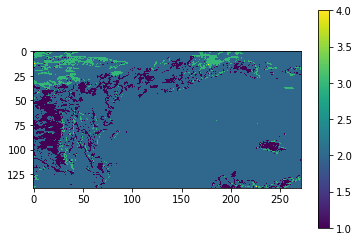

In [319]:
plt.imshow(summe[6][103:242,352:624])
plt.colorbar()

In [14]:
data_path = "/vols/satellit/home/lenk/data/radar_track/trackdata/hires/"

In [19]:
cases = glob.glob("{}haci_trackdata_20130618_*.nc".format(data_path))

In [21]:
case_data = xr.open_dataset(cases[0])

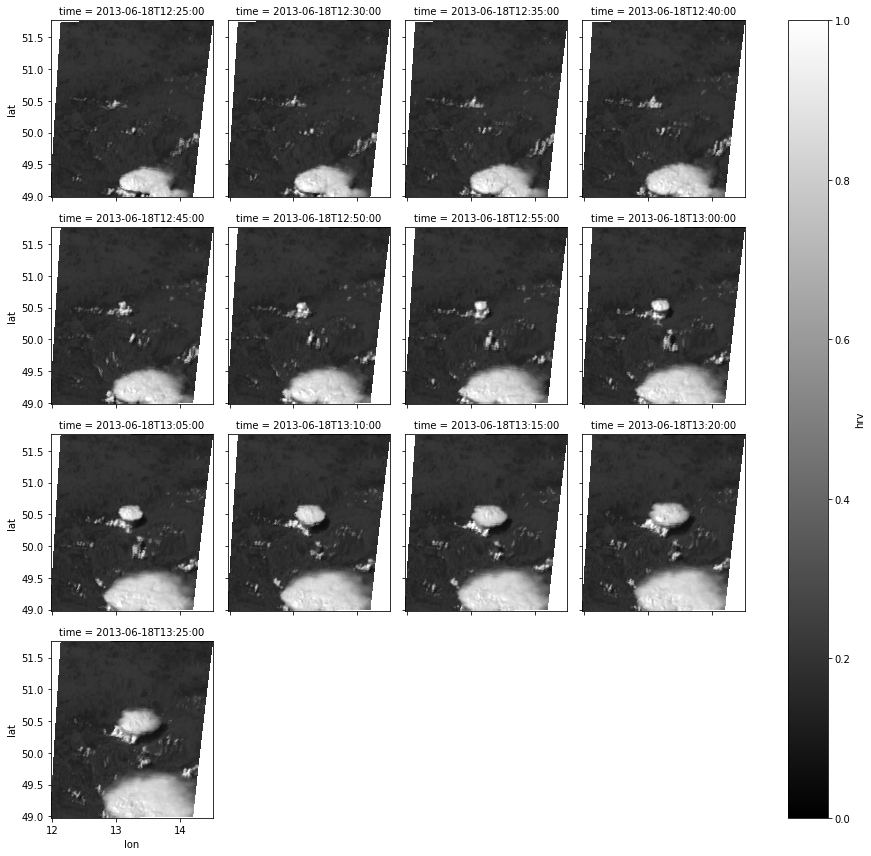

In [23]:
case_data.hrv.plot(x='lon',y='lat',col='time',col_wrap=4,vmin=0,vmax=1,cmap='gray')

In [219]:
case_data1 = xr.open_dataset(cases[1])

Um die Interessenfelder berechnen zu können, brauchen wir Lagrange'sche Felder. Dafür müssen wir die Felder verschieben.

Zuerst ermitteln wir den fünfminütigen Fluss.

In [125]:
flow5 = oft.calculate_optical_flow(case_data.ir108.data,'farnebaeck',filtering=True)

Und dann den fünfzehnminütigen.

In [128]:
flow15 = oft.calculate_optical_flow(case_data.ir108.data[::3],'farnebaeck',filtering=True)

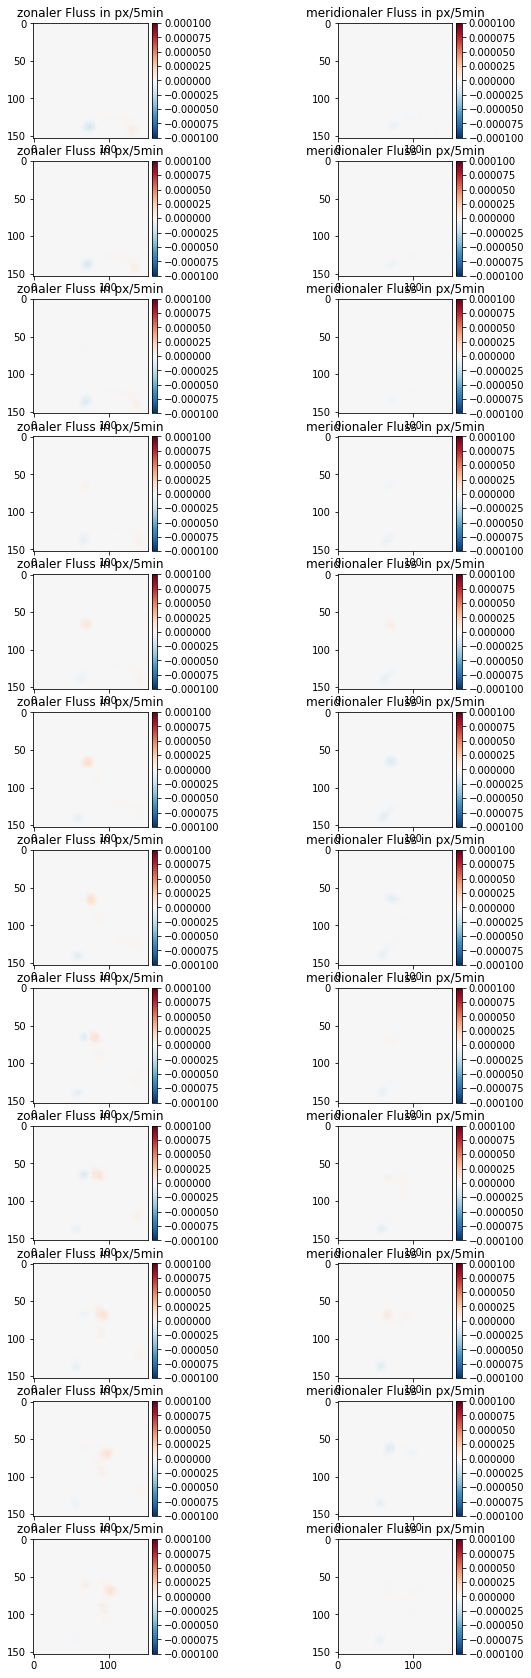

In [127]:
fig,ax = plt.subplots(12,2,figsize=(10,30))
for i, fl in enumerate(flow5):
    u_plot = ax[i,0].imshow(fl[...,0],vmin=-0.0001,vmax=0.0001, cmap='RdBu_r')
    fc.colourbar(u_plot)
    ax[i,0].set_title("zonaler Fluss in px/5min")
    v_plot = ax[i,1].imshow(fl[...,1],vmin=-0.0001,vmax=0.0001, cmap='RdBu_r')
    fc.colourbar(v_plot)
    ax[i,1].set_title("meridionaler Fluss in px/5min")

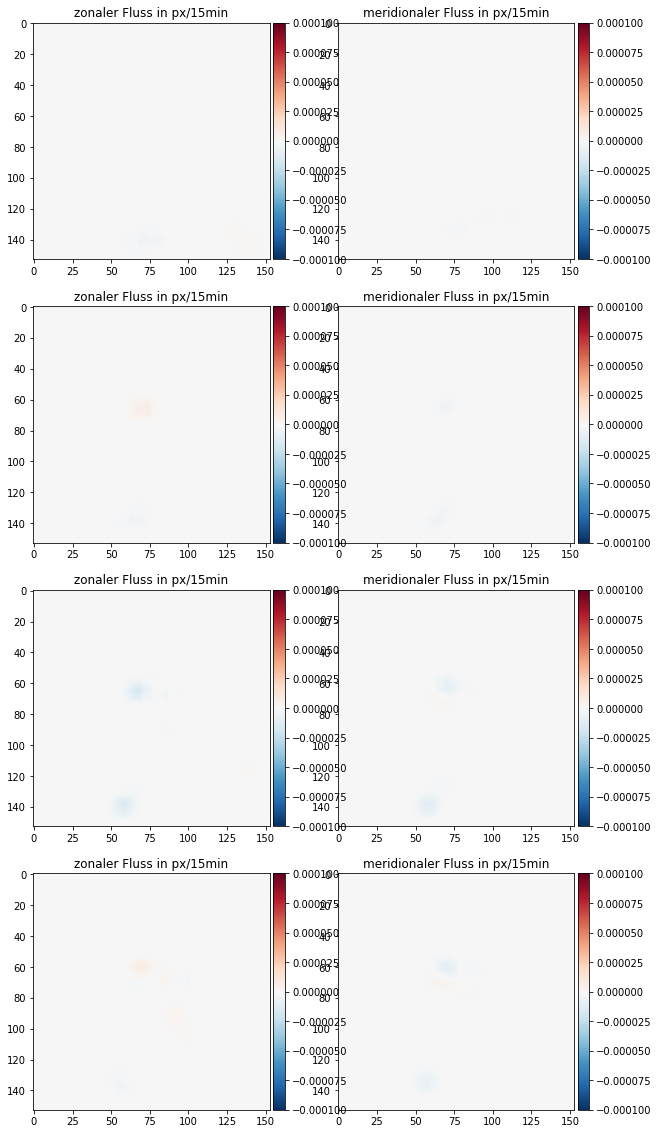

In [132]:
fig,ax = plt.subplots(4,2,figsize=(10,20))
for i, fl in enumerate(flow15):
    u_plot = ax[i,0].imshow(fl[...,0],vmin=-0.0001,vmax=0.0001, cmap='RdBu_r')
    fc.colourbar(u_plot)
    ax[i,0].set_title("zonaler Fluss in px/15min")
    v_plot = ax[i,1].imshow(fl[...,1],vmin=-0.0001,vmax=0.0001, cmap='RdBu_r')
    fc.colourbar(v_plot)
    ax[i,1].set_title("meridionaler Fluss in px/15min")

Dann maskieren wir die Daten mit der Wolkenmaske.

In [139]:
ct_mask = np.ma.masked_less(np.ma.masked_greater(case_data.ct.data,10),5)

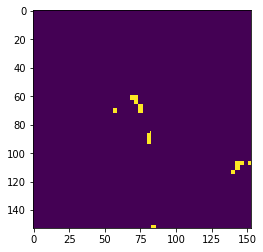

In [145]:
plt.imshow(case_data.ct.data[5])

In [181]:
interest_fields = {}

In [182]:
static_fields = ['wv062_ir108', 'wv062_wv073','ir087_ir108','tri','ir108']

In [183]:
interest_fields['wv062_ir108'] = case_data.wv062.data -case_data.ir108.data
interest_fields['wv062_wv073'] = case_data.wv062.data - case_data.wv073.data
interest_fields['ir087_ir108'] = case_data.ir087.data - case_data.ir108.data
interest_fields['tri'] = (case_data.ir087.data - case_data.ir108.data) - (case_data.ir108.data - case_data.ir120.data)
interest_fields['ir108'] = case_data.ir108.data

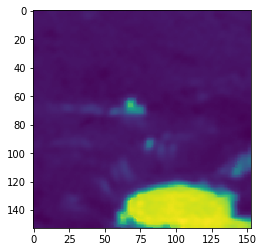

In [143]:
plt.imshow(interest_fields['wv062_ir108'][4])

In [159]:
interest_fields['wv062_ir108'][4].shape

(153, 153)

In [184]:
static_fields = ['wv062_ir108', 'wv062_wv073','ir087_ir108','tri','ir108']
for i,fl in enumerate(flow5):
    for f in static_fields:
        if not "{}_dt5".format(f) in interest_fields:
            interest_fields["{}_dt5".format(f)] = []
            interest_fields["{}_dt5".format(f)].append(np.zeros((153,153)))
            
        f_shifted = tco.morph_field(interest_fields[f][i],fl[...,0],fl[...,1])
        
        interest_fields["{}_dt5".format(f)].append(interest_fields[f][i+1] - f_shifted)

In [188]:
for i,fl in enumerate(flow15):
    for f in static_fields:
        if not "{}_dt15".format(f) in interest_fields:
            interest_fields["{}_dt15".format(f)] = []
            interest_fields["{}_dt15".format(f)].append(np.zeros((153,153)))
            
        f_shifted = tco.morph_field(interest_fields[f][i],fl[...,0],fl[...,1])
        
        interest_fields["{}_dt15".format(f)].append(interest_fields[f][i+1] - f_shifted)

In [180]:
hasattr(interest_fields, "{}_dt5".format(f))

False

In [214]:
isum = dict()
for k in thresholds.keys():
    lo = thresholds[k][0]
    up = thresholds[k][1]
    
    ind = np.zeros_like(interest_fields[k])
    
    if_val = np.array(interest_fields[k])
    valid_idx = np.where(np.logical_and(if_val>lo, if_val<up))
    
    ind[valid_idx] = 1
    isum[k] = ind

In [217]:
isum

{'ir087_ir108': array([[[1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         ...,
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 0., 1., 0.]],
 
        [[1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         ...,
         [1., 1., 1., ..., 0., 0., 1.],
         [1., 1., 1., ..., 0., 1., 0.],
         [1., 1., 1., ..., 0., 0., 0.]],
 
        [[1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         ...,
         [1., 1., 1., ..., 0., 0., 0.],
         [1., 1., 1., ..., 0., 0., 0.],
         [1., 1., 1., ..., 0., 0., 0.]],
 
        ...,
 
        [[1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         ...,
         [1., 1., 1., ..., 0., 0., 0.],
         [1., 1., 1., ...

In [201]:
np.array(interest_fields[k])

array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[ 9.03693387e-02,  2.13104248e-01,  2.18963623e-01, ...,
          2.01514358e-01,  2.32642288e-01,  2.23441880e-01],
        [ 1.92474365e-01,  2.00714111e-01,  3.20915264e-01, ...,
          7.19288945e-02,  1.97044175e

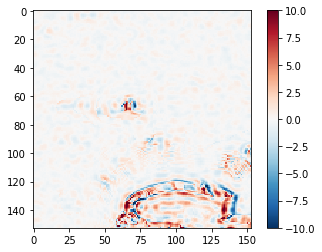

In [190]:
plt.imshow(interest_fields['tri_dt15'][3],vmin=-10,vmax=10,cmap='RdBu_r')
plt.colorbar()

In [97]:
tlist = [pd.Timestamp(t).strftime('%Y%m%d_%H%M') for t in case_data.time.data]

In [98]:
tlist

['20130618_1225',
 '20130618_1230',
 '20130618_1235',
 '20130618_1240',
 '20130618_1245',
 '20130618_1250',
 '20130618_1255',
 '20130618_1300',
 '20130618_1305',
 '20130618_1310',
 '20130618_1315',
 '20130618_1320',
 '20130618_1325']

In [99]:
for t in tlist:
    %run /vols/satellit/home/lenk/lib/citroPy/run_citro_for_tstamp.py {t}

... read satellite data for 20130618_1155
... read satellite data for 20130618_1210
... read satellite data for 20130618_1225
... save CI detections to /vols/satellit/home/lenk/data/cloudtype_analysis/ci/ci_indicators_20130618_1225.h5
... read satellite data for 20130618_1200
... read satellite data for 20130618_1215
... read satellite data for 20130618_1230
... save CI detections to /vols/satellit/home/lenk/data/cloudtype_analysis/ci/ci_indicators_20130618_1230.h5
... read satellite data for 20130618_1205
... read satellite data for 20130618_1220
... read satellite data for 20130618_1235
... save CI detections to /vols/satellit/home/lenk/data/cloudtype_analysis/ci/ci_indicators_20130618_1235.h5
... read satellite data for 20130618_1210
... read satellite data for 20130618_1225
... read satellite data for 20130618_1240
... save CI detections to /vols/satellit/home/lenk/data/cloudtype_analysis/ci/ci_indicators_20130618_1240.h5
... read satellite data for 20130618_1215
... read satellite

In [123]:
with h5py.File("/vols/satellit/home/lenk/data/cloudtype_analysis/ci/ci_indicators_20130618_1305.h5") as hfile:
    outdict= {k:[] for k in hfile.keys()}
    
    for k in hfile.keys():
        print hfile[k]
        if len(hfile[k]>1):
            for f in hfile[k]:
                outdict[k][f] = hfile[k][f][:]
        else:
            outdict[k] = hfile[k][:]

<HDF5 group "/base_fields" (10 members)>


TypeError: object of type 'bool' has no len()

In [111]:
outdict.keys()

[u'base_fields',
 u'mask_berendes',
 u'indicator_sum',
 u'mask_nwcsaf',
 u'interest_fields']

In [118]:
outdict['indicator_sum']

<Closed HDF5 dataset>